In [145]:
import tensorflow as tf
import gpflow
import numpy as np
import matplotlib.pyplot as plt

from trieste.data import Dataset
from trieste.models.gpflow import GaussianProcessRegression
from trieste.models.interfaces import TrainablePredictJointReparamModelStack
from trieste.objectives.utils import mk_observer
from trieste.observer import OBJECTIVE

from trieste.acquisition import ExpectedHypervolumeImprovement
from trieste.acquisition.rule import EfficientGlobalOptimization
from trieste.acquisition.function.multi_objective import HIPPO, hippo_penalizer

import test_functions

In [146]:
def create_grid(mins, maxs, grid_density=20):
    """
    Creates a regular 2D grid of size `grid_density^2` between mins and maxs.
    :param mins: list of 2 lower bounds
    :param maxs: list of 2 upper bounds
    :param grid_density: scalar
    :return: Xplot [grid_density**2, 2], xx, yy from meshgrid for the specific formatting of contour / surface plots
    """
    xspaced = np.linspace(mins[0], maxs[0], grid_density)
    yspaced = np.linspace(mins[1], maxs[1], grid_density)
    xx, yy = np.meshgrid(xspaced, yspaced)
    Xplot = np.vstack((xx.flatten(), yy.flatten())).T

    return Xplot, xx, yy

In [147]:
def build_stacked_independent_objectives_model(data, n_obj):
    gprs = []
    for idx in range(n_obj):
        single_obj_data = Dataset(
            data.query_points, tf.gather(data.observations, [idx], axis=1)
        )
        variance = tf.math.reduce_variance(single_obj_data.observations)
        kernel = gpflow.kernels.Matern52(variance, tf.constant(0.2, tf.float64))
        gpr = gpflow.models.GPR(single_obj_data.astuple(), kernel, noise_variance=1e-5)
        gpflow.utilities.set_trainable(gpr.likelihood, False)
        gprs.append((GaussianProcessRegression(gpr), 1))

    return TrainablePredictJointReparamModelStack(*gprs)

In [148]:
test_f = test_functions.Simple1D()
observer = mk_observer(test_f, OBJECTIVE)

In [149]:
n_initial_points = 20
initial_query_points = test_f.search_space.sample(n_initial_points)
initial_data = observer(initial_query_points)

In [150]:
base_acq = ExpectedHypervolumeImprovement().using(OBJECTIVE)
acq_fn_builder = HIPPO(objective_tag=OBJECTIVE, base_acquisition_function_builder=base_acq)

In [151]:
models = build_stacked_independent_objectives_model(initial_data[OBJECTIVE], test_f.n_objectives)

In [152]:
acq_rule = EfficientGlobalOptimization(num_query_points=3, builder=acq_fn_builder)

In [153]:
if test_f.search_space.dimension > 1:
    grid, xx, yy = create_grid(test_f.search_space.lower, test_f.search_space.upper, grid_density=80)
else:
    xx = np.linspace(test_f.search_space.lower[0], test_f.search_space.upper[0], 200)

In [154]:
plt.rcParams['text.usetex'] = False
plt.rcParams["figure.figsize"] = (7,8)

### Point 1

In [155]:
acq_fn_1 = acq_rule._builder.prepare_acquisition_function({OBJECTIVE: models}, initial_data)
points_1 = acq_rule._optimizer(test_f.search_space, acq_fn_1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


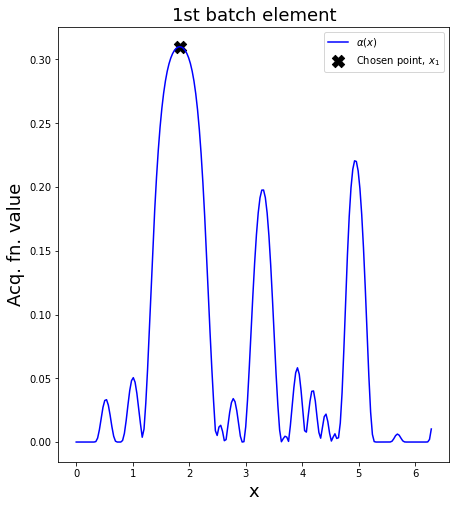

In [156]:
if test_f.search_space.dimension == 1:
    acq_evals_1 = acq_fn_1(xx.reshape(-1, 1, 1)).numpy()
    plt.plot(xx, acq_evals_1.reshape(*xx.shape), c='b', label=r'$\alpha(x)$')
    plt.scatter(points_1[0], acq_fn_1(points_1.numpy().reshape(-1, 1, 1))[0], c='k', marker='X', s=150, label=r'Chosen point, $x_1$')
    plt.title("1st batch element", fontsize=18)
    plt.xlabel('x', fontsize=18)
    plt.ylabel('Acq. fn. value', fontsize=18)
    plt.legend()
    plt.savefig('1st_bach_element.eps', format='eps')
    plt.show()
else:
    acq_evals_1 = acq_fn_1(grid.reshape(-1, 1, 2)).numpy()

    levels = 30
    c = plt.contourf(xx, yy, acq_evals_1.reshape(*xx.shape), levels, alpha=0.9)
    plt.colorbar(c)
    plt.scatter(points_1[:, 0], points_1[:, 1], c='r', marker='X', s=5)

### Point 2

In [157]:
acq_fn_2 = acq_rule._builder.update_acquisition_function(
                    acq_fn_1,
                    {OBJECTIVE: models}, initial_data,
                    pending_points=points_1,
                    new_optimization_step=False,
                )
chosen_point_2 = acq_rule._optimizer(test_f.search_space, acq_fn_2)
points_2 = tf.concat([points_1, chosen_point_2], axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


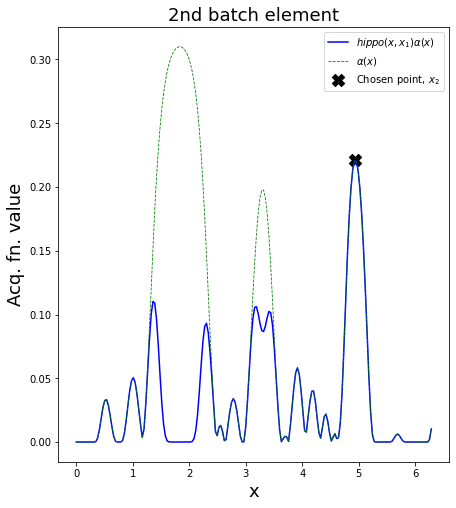

In [158]:
if test_f.search_space.dimension == 1:
    acq_evals_2 = acq_fn_2(xx.reshape(-1, 1, 1)).numpy()
#     hippo_evals = acq_rule._builder._penalization(xx.reshape(-1, 1, 1)).numpy()
    plt.plot(xx, acq_evals_2.reshape(*xx.shape), c='b', label=r'$hippo(x, x_1) \alpha(x)$')
    plt.plot(xx, acq_evals_1.reshape(*xx.shape), 'g--', linewidth=0.8, label=r'$\alpha(x)$')
#     plt.plot(xx, hippo_evals.reshape(*xx.shape), c='g')
    plt.scatter(chosen_point_2[0], acq_fn_2(chosen_point_2.numpy().reshape(-1, 1, 1))[0], c='k', marker='X', s=150, label=r'Chosen point, $x_2$')
    plt.title("2nd batch element", fontsize=18)
    plt.xlabel('x', fontsize=18)
    plt.ylabel('Acq. fn. value', fontsize=18)
    plt.legend()
    plt.savefig('2nd_bach_element.eps', format='eps')
    plt.show()
else:
    acq_evals_2 = acq_fn_2(grid.reshape(-1, 1, 2)).numpy()

    levels = 30
    c = plt.contourf(xx, yy, acq_evals_2.reshape(*xx.shape), levels, alpha=0.9)
    plt.colorbar(c)
    plt.scatter(chosen_point_2[:, 0], chosen_point_2[:, 1], c='r', marker='X')

### Point 3

In [159]:
acq_fn_3 = acq_rule._builder.update_acquisition_function(
                    acq_fn_2,
                    {OBJECTIVE: models}, initial_data,
                    pending_points=points_2,
                    new_optimization_step=False,
                )
chosen_point_3 = acq_rule._optimizer(test_f.search_space, acq_fn_3)
points_3 = tf.concat([points_2, chosen_point_3], axis=0)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


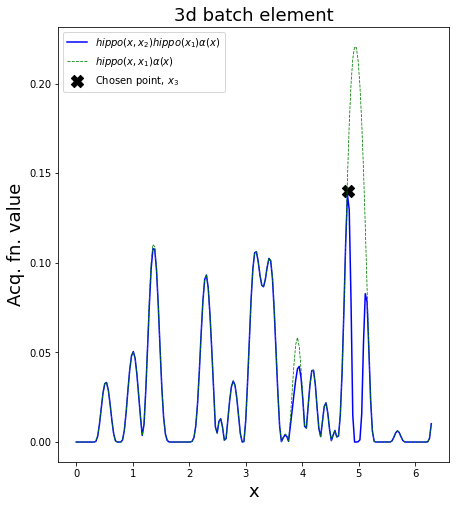

In [160]:
if test_f.search_space.dimension == 1:
    acq_evals_3 = acq_fn_3(xx.reshape(-1, 1, 1)).numpy()
    plt.plot(xx, acq_evals_3.reshape(*xx.shape), c='b', label=r'$hippo(x, x_2) hippo(x_1) \alpha(x)$')
    plt.plot(xx, acq_evals_2.reshape(*xx.shape), 'g--', linewidth=0.8, label=r'$hippo(x, x_1) \alpha(x)$')
    plt.scatter(chosen_point_3[0], acq_fn_3(chosen_point_3.numpy().reshape(-1, 1, 1))[0], c='k', marker='X', s=150, label=r'Chosen point, $x_3$')
    plt.title("3d batch element", fontsize=18)
    plt.xlabel('x', fontsize=18)
    plt.ylabel('Acq. fn. value', fontsize=18)
    plt.legend()
    plt.savefig('3rd_bach_element.eps', format='eps')
    plt.show()
else:
    acq_evals_3 = acq_fn_3(grid.reshape(-1, 1, 2)).numpy()

    levels = 30
    c = plt.contourf(xx, yy, acq_evals_3.reshape(*xx.shape), levels, alpha=0.9)
    plt.colorbar(c)
    plt.scatter(chosen_point_3[:, 0], chosen_point_3[:, 1], c='r')